# TensorFlow - Keras ile CNN Yazmak

#### Daha önce hazırladığım notebookların linkleri:

* **TensorFlow'a Giriş Notebook'um:** https://github.com/Frightera/TensorFlow-2.X-Ogretici-Notebooklar/blob/main/0%20-%20TensorFlow'a_Giri%C5%9F.ipynb


* **TF - Keras ile Lineer Regresyon ve Patlayan Gradyanlar:** https://github.com/Frightera/TensorFlow-2.X-Ogretici-Notebooklar/blob/main/1%20-%20Lineer%20Regresyon%20ve%20Patlayan%20Gradyanlar.ipynb


* **TF-Keras ile Lineer Olmayan Regresyon, Aktivasyonlar ve Layer Subclassing:** https://github.com/Frightera/TensorFlow-2.X-Ogretici-Notebooklar/blob/main/2%20-%20Lineer%20Olmayan%20Regresyon%2C%20Aktivasyonlar%20ve%20Layer%20Subclassing.ipynb


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, \
                                    LeakyReLU, Conv2D, Flatten, \
                                    MaxPooling2D

fashion_mnist = tf.keras.datasets.fashion_mnist

import matplotlib.pyplot as plt

import numpy as np
import time

from sklearn.metrics import confusion_matrix, classification_report

print('TF Version:', tf.__version__)

TF Version: 2.6.0


## Veriyi İlk Başta Keras ile Yüklemek

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
print(type(train_images))
print(type(train_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
# Eğitim verisi 60000 tane 28 x 28 resimlerden oluşuyor.
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


## Veriyi Görselleştirme

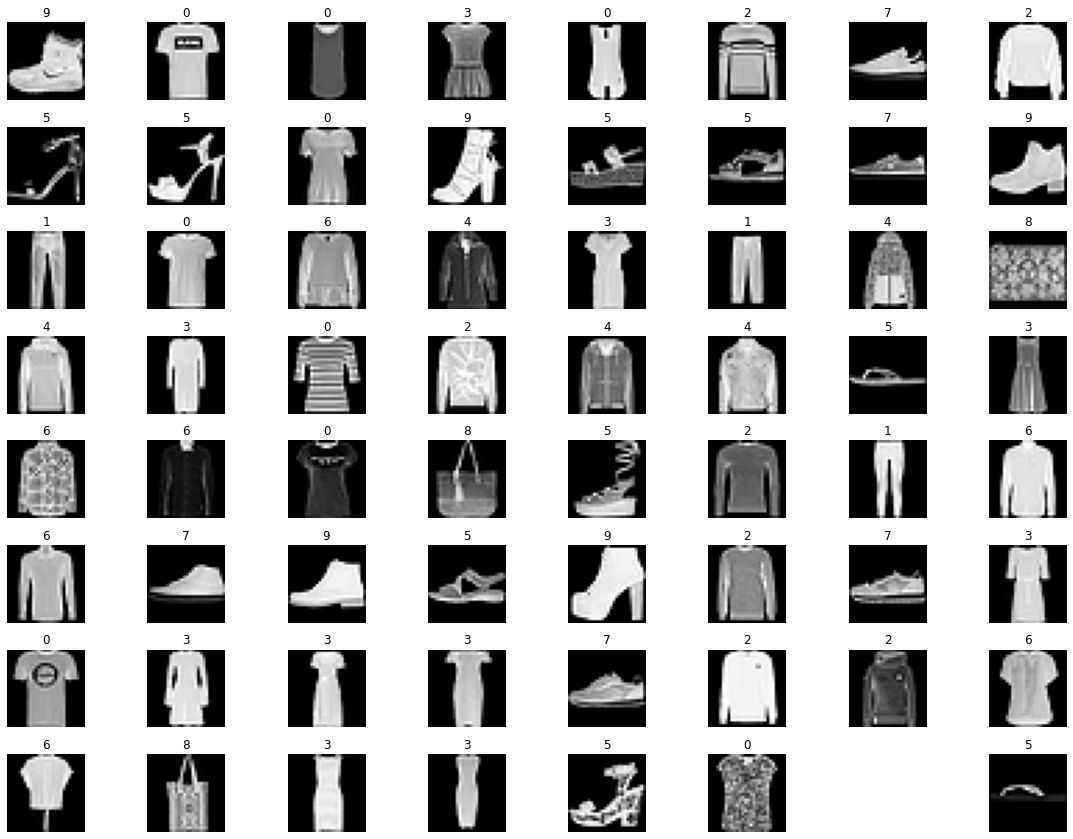

In [5]:
"""
Görüldüğü üzere labellar tam sayı ile kodlanmış.
Loss fonksiyonunu seçerken bunu göz önünde bulunduracağız.
"""
plt.figure(figsize = (16, 12))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(train_images[i], cmap = plt.cm.gray)
    plt.title(train_labels[i])
    plt.tight_layout()
    plt.axis('off')

## 1) TensorFlow-Keras ile basit bir CNN
* 2 tane convolution operasyonundan oluşan bir CNN yazalım.


* TF-Keras kullanırken Conv2D layerına verdiğimiz inputun 4 boyutlu olması gerekiyor. (batch size dahil)


* Burada `train_images`'in shape'i (60000, 28, 28)'di. Resimlerimiz grayscale olduğu için
  ve Conv2D'nin beklentisine uygun vermemiz gerektiği için fazladan boyut ekleyeceğiz. 
  Sonuç olarak shape **(60000, 28, 28, 1)** olmalı.

In [6]:
print('Önceki: ', train_images.shape)

train_images = train_images.astype(np.float32) / 255.0 # normalize et
test_images = test_images.astype(np.float32) / 255.0 # normalize et

train_images = np.expand_dims(train_images, axis = -1)
test_images = np.expand_dims(test_images, axis = -1)

print('Sonrası:', train_images.shape)

Önceki:  (60000, 28, 28)
Sonrası: (60000, 28, 28, 1)


* Önce modelleri oluşturalım sonra üzerinden geçelim.

In [7]:
# İlk başta Sequential API kullanalım.

model_seq = tf.keras.Sequential([
                 Conv2D(32, 3, input_shape = (28, 28, 1)),
                 LeakyReLU(alpha = 0.2),
                 MaxPooling2D(3),
                 
                 Conv2D(64, 3),
                 LeakyReLU(alpha = 0.2),
                 GlobalMaxPooling2D(),
                 
                 Dense(128),
                 LeakyReLU(alpha = 0.2),
    
                 # 10 tane sınıf olduğu için sonda 
                 # softmax ve 10 dense unit kullandık.
                 Dense(10, activation = tf.nn.softmax)    
])
model_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 6, 64)          0         
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

In [8]:
# Aynısını Functional API ile yazalım.
# Functional API ile modele birden fazla input ve output verecek şekilde tasarlayabiliriz.

# Örn: Bounding box regression(object detection) yapan modeller 2 farklı output verir.
# Birisi classification için, diğeri ise çizilen bounding box içindir.

# Notebook'un sonunda biz de bir inputu iki farklı şekilde paylaştıracağız.

input_layer = tf.keras.Input(shape = (28, 28, 1))
# Bu layerı, bir sonrakinin yanına parantez içinde yazıyorum.

x = Conv2D(32, 3)(input_layer)
# 32 filtre, 3x3 kernel size.

x = LeakyReLU(alpha = 0.2)(x) # Aktivasyon olarak.

# Uyguladığımız max pool. boyutu 3x3
x = MaxPooling2D(3)(x)

x = Conv2D(64, 3)(x)
# 64 filtre, 3x3 kernel size.
x = LeakyReLU(alpha = 0.2)(x)

x = GlobalMaxPooling2D()(x) # Altta açıklanacak.
#x = Flatten()(x) 
# Flatten & GlobalPooling: İkisinden birisi olabilir.
# Farklı şekilde davranıyorlar.

x = Dense(128)(x)
x = LeakyReLU(alpha = 0.2)(x)

# 10 tane sınıf olduğu için sonda 
# softmax ve 10 dense unit kullandık.
x = Dense(10, activation = tf.nn.softmax)(x)

# Bu layerların bir model oluşturacağını söylüyoruz ve 
# input ve outputları kendimiz veriyoruz.
model_func = tf.keras.Model(inputs = input_layer,
                            outputs = x)
model_func.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6, 6, 64)          0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 64)                0     

## Flatten vs GlobalMaxPooling2D

* CNN modelleri yazarken, convolution operasyonlarından sonra Flatten veya GlobalPooling
  layerları kullanılır. Bunun nedeni çıktının bir dense layera verilip ondan sonra tahmin yapılacak
  olmasıdır. Yani 2D CNN'den çıkan 4 boyutlu çıktıyı 2 boyuta düşürmemiz gerekiyor.
  
  
* İkisi benzer görünse de yaptıkları işler farklıdır.

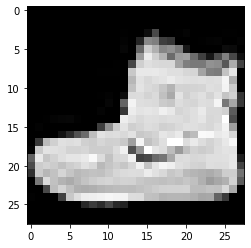

In [9]:
# deneme için ilk resmi alalım
first_image = train_images[0]
plt.imshow(first_image, cmap = plt.cm.gray)
plt.show()

In [10]:
print('Batch dim. eklemeden önce:', first_image.shape)

first_image = np.expand_dims(first_image, axis = 0)

print("Batch dim. ekledikten sonra:", first_image.shape)

Batch dim. eklemeden önce: (28, 28, 1)
Batch dim. ekledikten sonra: (1, 28, 28, 1)


**Flatten**

Flatten şuanki durumda `(batch_size, yükseklik, genişlik, kanallar)` olarak gelen girdinin 2 boyuta düşürülmesini sağlar. Bunu da `reshape` kullanarak yapar. Sonuç olarak çıktımız `(batch_size, yükseklik x genişlik x kanallar)` olacaktır.

In [11]:
flatten = first_image.reshape(first_image.shape[0], -1)
tf_keras_flatten = Flatten()(first_image).numpy()

print("Normal resmin shape'i:", first_image.shape)
print("Flatten sonrası:", flatten.shape)

# TF-Keras layerı ile karşılaştırma
print('Eşitlik kontrolü:', np.allclose(flatten, tf_keras_flatten))

# Yani Flatten modellerde parametre sayısını artırabilir. Ama en az GlobalPooling kadar parametresi olacaktır.

Normal resmin shape'i: (1, 28, 28, 1)
Flatten sonrası: (1, 784)
Eşitlik kontrolü: True


**GlobalMaxPooling2D**

GlobalMaxPooling2D de aynı şekilde bu durumda gelen 4 boyutlu bir girdiyi 2 boyuta düşürmeye yarar. Tüm kanallar için yükseklik ve genişlik boyutlarının maksimumunu alarak bunu halleder. Sonuç olarak `(batch_size, kanal_sayısı)` döndürür.

In [12]:
GlobalMaxPool = first_image.max(axis=(1,2))
tf_keras_GlobalMaxPool2D = GlobalMaxPooling2D()(first_image).numpy()

print("Normal resmin shape'i:", first_image.shape)
print("GlobalMaxPool sonrası:", GlobalMaxPool.shape)

print('Eşitlik kontrolü:', np.allclose(GlobalMaxPool,
                                       tf_keras_GlobalMaxPool2D))

Normal resmin shape'i: (1, 28, 28, 1)
GlobalMaxPool sonrası: (1, 1)
Eşitlik kontrolü: True


## Training Aşaması

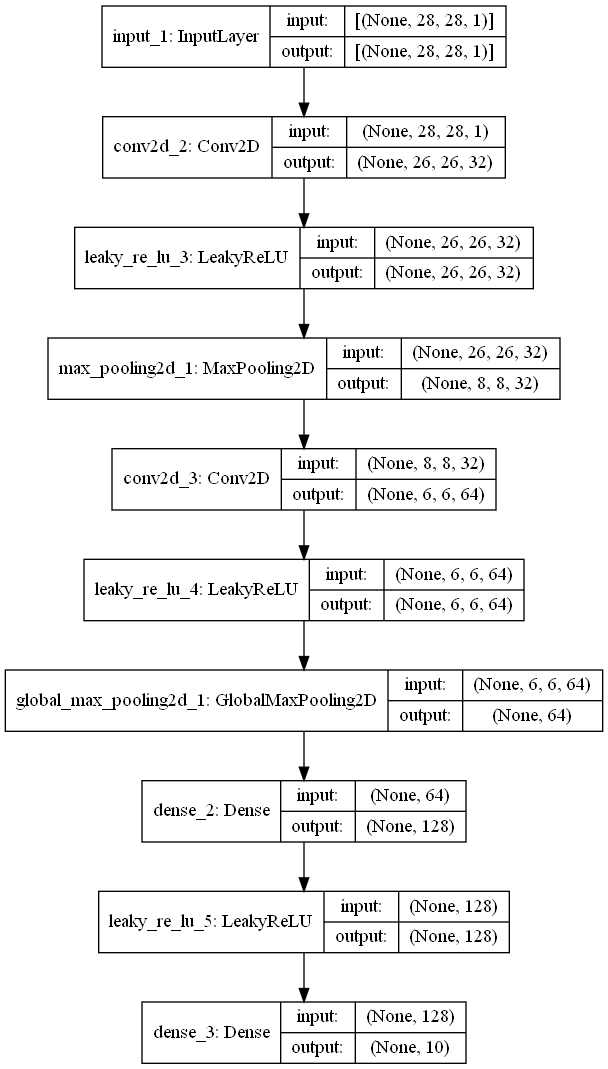

In [13]:
# Modeli Plot edelim
# Dümdüz basit bir model.
tf.keras.utils.plot_model(model_func, 'model.png', show_shapes = True)

In [14]:
# Adaptive optimizer olan Adam'ı kullanalım.
opt = tf.keras.optimizers.Adam()

# Labellarımız tam sayı olduğu için sparse categorical cross entr. kullandık.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
print("Örnek labellar:", train_labels[:10])

"""
Labellar one-hot-encoding biçiminde de olabilirdi. O zaman loss olarak
tf.keras.losses.CategoricalCrossentropy() kullanmalıydık.
"""
print("\nOne-hot-encoding uygulanmış olsaydı:\n", tf.keras.utils.to_categorical(train_labels[:10]))


model_func.compile(optimizer = opt, loss = loss_fn,
                   metrics = ['accuracy'])

Örnek labellar: [9 0 0 3 0 2 7 2 5 5]

One-hot-encoding uygulanmış olsaydı:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [15]:
history = model_func.fit(train_images, train_labels, epochs = 16,
               validation_data = (test_images, test_labels),
               batch_size = 128, validation_batch_size = 128)

Epoch 1/16
469/469 [==============================] - 8s 8ms/step - loss: 0.7697 - accuracy: 0.7270 - val_loss: 0.5379 - val_accuracy: 0.8009
Epoch 2/16
469/469 [==============================] - 3s 7ms/step - loss: 0.4611 - accuracy: 0.8323 - val_loss: 0.4452 - val_accuracy: 0.8401
Epoch 3/16
469/469 [==============================] - 3s 7ms/step - loss: 0.4000 - accuracy: 0.8549 - val_loss: 0.4056 - val_accuracy: 0.8558
Epoch 4/16
469/469 [==============================] - 3s 7ms/step - loss: 0.3654 - accuracy: 0.8694 - val_loss: 0.3932 - val_accuracy: 0.8617
Epoch 5/16
469/469 [==============================] - 3s 7ms/step - loss: 0.3391 - accuracy: 0.8781 - val_loss: 0.3771 - val_accuracy: 0.8674
Epoch 6/16
469/469 [==============================] - 3s 7ms/step - loss: 0.3248 - accuracy: 0.8833 - val_loss: 0.3602 - val_accuracy: 0.8708
Epoch 7/16
469/469 [==============================] - 3s 7ms/step - loss: 0.3087 - accuracy: 0.8877 - val_loss: 0.3295 - val_accuracy: 0.8825
Epoch 

In [16]:
model_func.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.2966 - accuracy: 0.8969


[0.2965976297855377, 0.8968999981880188]

In [17]:
# History objesi bir dictionary döndürür.
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
# Eğitim sırasındaki loss değerlerine vb. erişebiliriz
history.history['loss'][:3]

[0.7696618437767029, 0.4611269533634186, 0.4000406861305237]

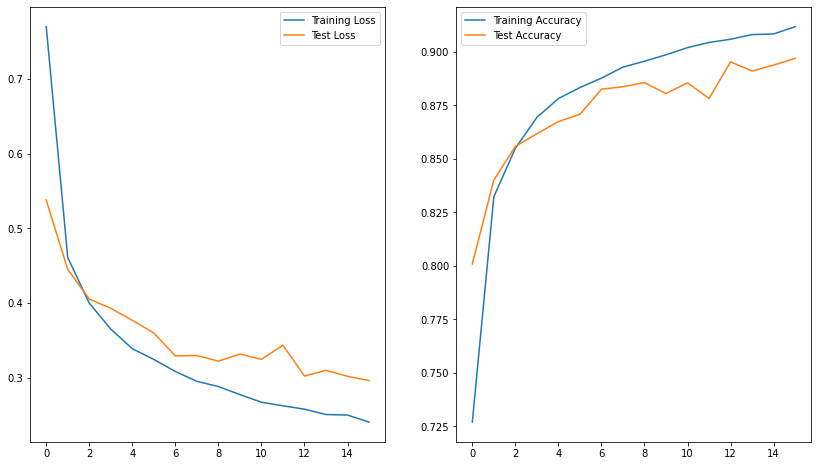

In [19]:
plt.figure(figsize = (14, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.legend()

## Bir Input İki Ayrı Model Yaklaşımı
* Şimdi Functional API kullanarak bir inputu iki farklı şekilde kullanacağız. 

* **Bu modeli Sequential API kullanarak yazamazdık.**


* Yazacağımız model Average Ensemble gibi düşünülebilir. Tam olarak öyle görünmese de, iki ayrı operasyondan gelen Dense layer çıktılarının ortalamasını alıp bir sınıflandırma yapacağız.

In [20]:
input_layer = tf.keras.Input(shape = (28, 28, 1))

# 1.operasyonlar serisi 
x = Conv2D(32, 3)(input_layer) # input_layerımızı buraya gönderdik.
x = LeakyReLU(alpha = 0.2)(x) # Aktivasyon olarak.
x = MaxPooling2D(3)(x)

x = Conv2D(64, 3)(x)
x = LeakyReLU(alpha = 0.2)(x)

x = GlobalMaxPooling2D()(x)

x = Dense(128)(x)
x = LeakyReLU(alpha = 0.2)(x)
# 128'lik dense ile bitirelim.

# 2.operasyonlar serisi
y = Conv2D(16, 5)(input_layer) # Aynı inputu buraya da gönderdik.
y = LeakyReLU(alpha = 0.2)(y) # Aktivasyon olarak.
y = MaxPooling2D(3)(y)

y = Conv2D(32, 5)(y)
y = LeakyReLU(alpha = 0.2)(y)

y = Flatten()(y) 

y = Dense(128)(y)
y = LeakyReLU(alpha = 0.2)(y)
# 128'lik dense ile bitirelim.

average_layer = tf.keras.layers.Average()([x, y])
# 2 farklı operasyondan gelen değerlerin element-wise ortalamasını alalım.
# Shapeler eşleşmelidir. Onun için son 2 dense layerda 128 unit kullandık.

# Ortalama alınan değerleri çıkış katmanına verelim.
output = Dense(10, activation = tf.nn.softmax)(average_layer)

# Bu layerların bir model oluşturacağını söylüyoruz ve 
# input ve outputları kendimiz veriyoruz.
model_func = tf.keras.Model(inputs = input_layer,
                            outputs = output)
model_func.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 26, 26, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 24, 24, 16)   416         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 26, 26, 32)   0           conv2d_4[0][0]                   
____________________________________________________________________________________________

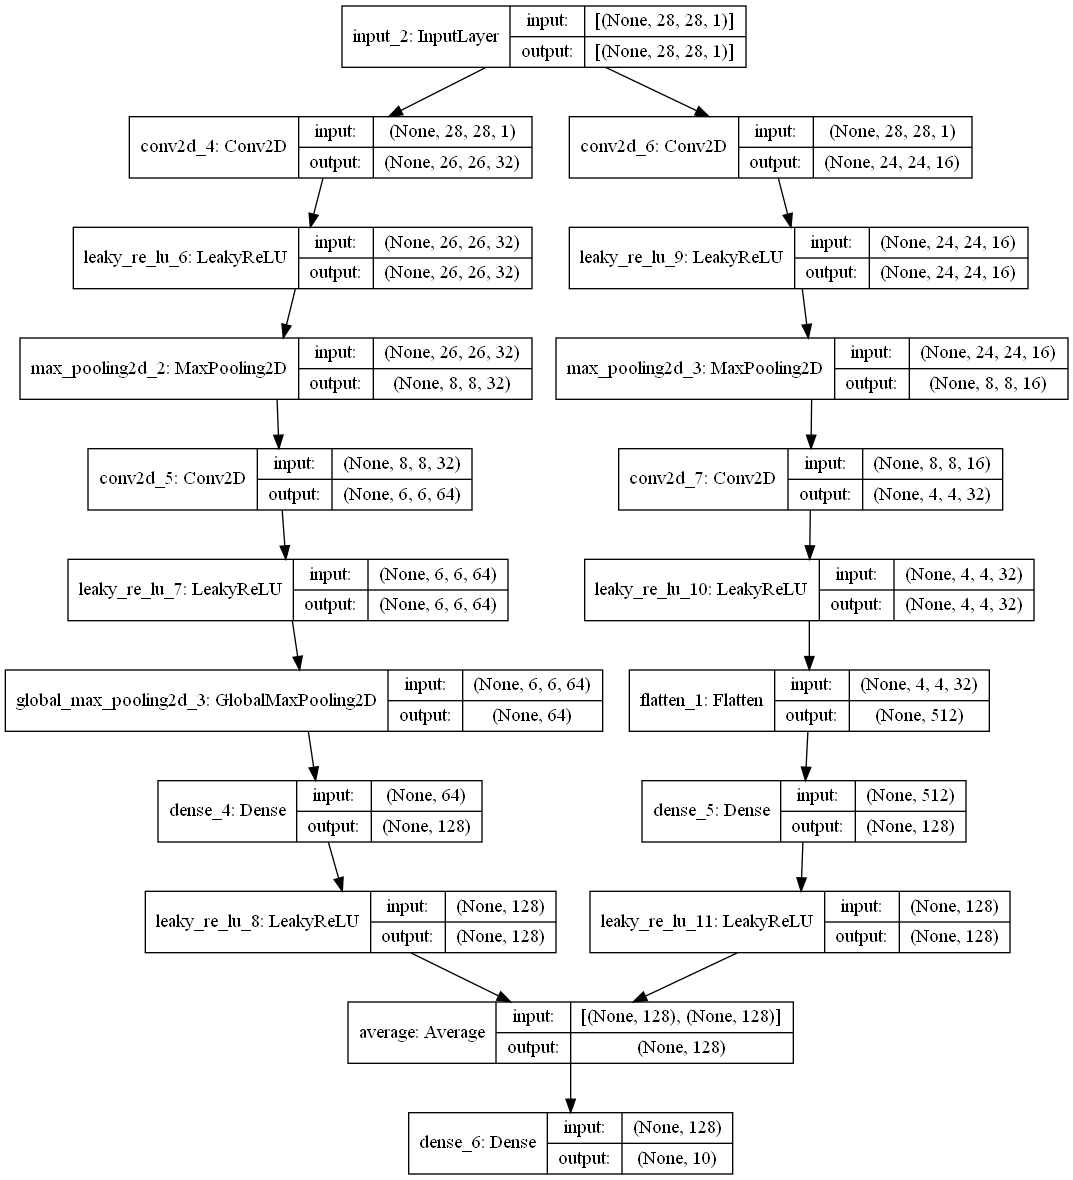

In [21]:
# Modeli Plot edelim
# Bir inputu iki farklı şekilde kullandık.
tf.keras.utils.plot_model(model_func, 'model.png', show_shapes = True)

In [22]:
# Adaptive optimizer olan Adam'ı kullanalım.
opt = tf.keras.optimizers.Adam()

# Labellarımız tam sayı olduğu için sparse categorical cross entr. kullandık.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model_func.compile(optimizer = opt, loss = loss_fn,
                   metrics = ['accuracy'])

In [23]:
history = model_func.fit(train_images, train_labels, epochs = 16, 
               validation_data = (test_images, test_labels),
               batch_size = 128, validation_batch_size = 128)

Epoch 1/16
469/469 [==============================] - 6s 11ms/step - loss: 0.5942 - accuracy: 0.7875 - val_loss: 0.4122 - val_accuracy: 0.8529
Epoch 2/16
469/469 [==============================] - 5s 10ms/step - loss: 0.3665 - accuracy: 0.8681 - val_loss: 0.3448 - val_accuracy: 0.8757
Epoch 3/16
469/469 [==============================] - 5s 11ms/step - loss: 0.3170 - accuracy: 0.8871 - val_loss: 0.3151 - val_accuracy: 0.8869
Epoch 4/16
469/469 [==============================] - 5s 10ms/step - loss: 0.2869 - accuracy: 0.8965 - val_loss: 0.2972 - val_accuracy: 0.8914
Epoch 5/16
469/469 [==============================] - 5s 10ms/step - loss: 0.2683 - accuracy: 0.9033 - val_loss: 0.2897 - val_accuracy: 0.8925
Epoch 6/16
469/469 [==============================] - 5s 10ms/step - loss: 0.2497 - accuracy: 0.9104 - val_loss: 0.2891 - val_accuracy: 0.8959
Epoch 7/16
469/469 [==============================] - 5s 10ms/step - loss: 0.2354 - accuracy: 0.9139 - val_loss: 0.2714 - val_accuracy: 0.9007

In [24]:
model_func.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.2534 - accuracy: 0.9118


[0.25343114137649536, 0.9118000268936157]

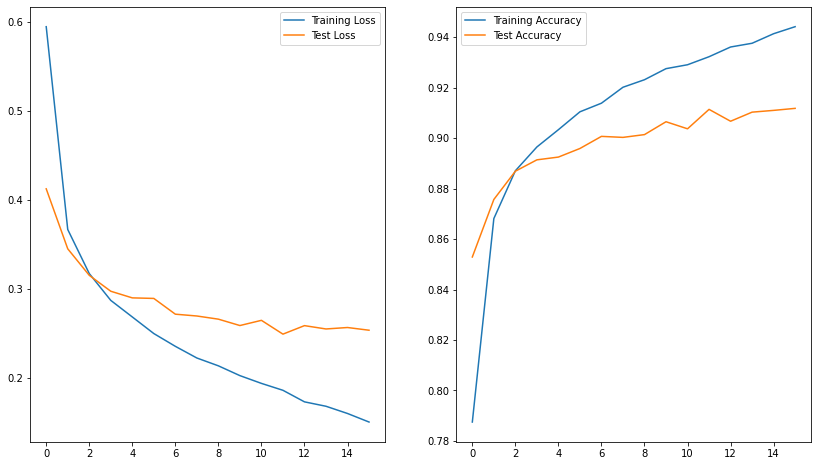

In [25]:
plt.figure(figsize = (14, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.legend()

In [26]:
test = test_images[500]
test.shape

(28, 28, 1)

In [27]:
model_func.predict(test) # Hata verecek.

ValueError: in user code:

    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\keras\layers\convolutional.py:249 call
        outputs = self._convolution_op(inputs, self.kernel)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\nn_ops.py:1131 convolution_v2
        return convolution_internal(
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\nn_ops.py:1261 convolution_internal
        return op(
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\nn_ops.py:2715 _conv2d_expanded_batch
        return gen_nn_ops.conv2d(
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:968 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    c:\users\kaan\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 5 from 1 for '{{node model_1/conv2d_6/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](model_1/ExpandDims, model_1/conv2d_6/Conv2D/ReadVariableOp)' with input shapes: [?,28,1,1], [5,5,1,16].


In [28]:
test = np.expand_dims(test, axis = 0) # Batch dimension ekledik.
# Yani modele kaç tane resim verdiğimizi söylememiz gerekiyor.
# Sonuçta, 1 tane 28 x 28 x 1 olan resim vereceğiz.
# Yeni shape:
test.shape

(1, 28, 28, 1)

In [29]:
np.set_printoptions(suppress=True) # Bilimsel gösterimi kapatmak için

result = model_func.predict(test)

In [30]:
# Softmax çıktıları olduğu için toplamları 1 yapacaktır.
# Buradakileri sınıfların olma olasılığı şekilde yorumlayabiliriz.
# Buradaki maximum olan indisi alırsak sınıf tahminini almış oluruz.
result

array([[0.03760951, 0.00007964, 0.9571122 , 0.00003335, 0.00277086,
        0.00000039, 0.00233074, 0.00000005, 0.00006297, 0.00000031]],
      dtype=float32)

In [31]:
# Toplamı
np.sum(result)

1.0

In [32]:
predicted = np.argmax(result, axis = -1)
predicted

array([2], dtype=int64)

In [33]:
# Model doğru bildi.
label = test_labels[500]
predicted[0] == label

True

In [34]:
# Confusion Matrix ve Classification Report için tüm test setini predict edelim.
predictions = model_func.predict(test_images)
predictions[:2]

array([[0.00000004, 0.        , 0.00000002, 0.        , 0.00000002,
        0.00000621, 0.00000027, 0.00010334, 0.00000037, 0.99988973],
       [0.00003011, 0.        , 0.99993813, 0.        , 0.00003143,
        0.        , 0.00000022, 0.        , 0.        , 0.        ]],
      dtype=float32)

In [35]:
predicted_classes = np.argmax(predictions, axis = -1)
predicted_classes[:2] # ilk iki indis.

array([9, 2], dtype=int64)

<AxesSubplot:>

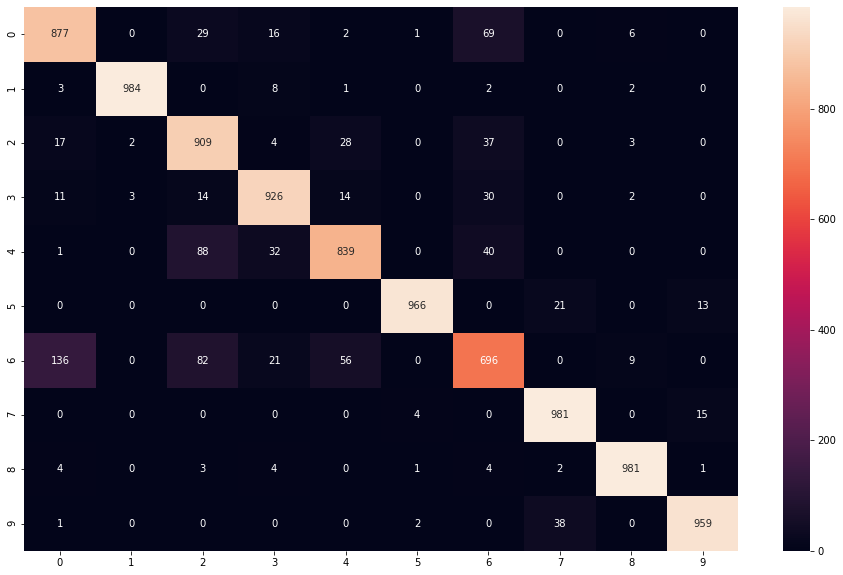

In [38]:
import seaborn as sns

# Artık tahminleri ve doğru sınıfları karşılaştırabiliriz.

# Dikey: Doğru Sınıflar
# Yatay: Tahmin Edilen Sınıflar

plt.figure(figsize = (16, 10))
cm = confusion_matrix(test_labels, predicted_classes)
sns.heatmap(cm, annot = True, fmt = 'd')

In [40]:
print(classification_report(test_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.81      0.91      0.86      1000
           3       0.92      0.93      0.92      1000
           4       0.89      0.84      0.86      1000
           5       0.99      0.97      0.98      1000
           6       0.79      0.70      0.74      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

